# Sunshine List gender analysis

*March 26, 2022*

The gender pay gap is well-researched, and[ validated in Ontario already](https://www.payequity.gov.on.ca/en/LearnMore/GWG/Pages/default.aspx). But what's really missing is an employer-by-employer comparison.

Let's try using the sunshine list to try to compare various public-sector employers in terms of their pay equity. The big problem: we don't have genders of the people on the sunshine list. Here's one way we could solve that problem.

First, we'll import pandas and set a global option to display floats with commas (just to make things more readable). We also use glob and python's regex module here too.

In [162]:
import pandas as pd
import glob         # For importing all our data in a loop.
import re           # Regex module for replacing the values in the year column to correct for an entry error.
from zipfile import ZipFile

pd.options.display.float_format = '{:,.2f}'.format

## 1. Preparing the data

There's a wealth of sunshine list data going back all the way to 2012, so we have a lot of data to pull together into one dataframe. It also needs some cleaning, as some of the files have different column names. There are also some errors in the year column of one file, so to get around that, we get the year from the filename and overwrite the year column with that data instead.

A quick note that we'll also just be looking at salary here, not benefits. Future analysis could sum salaries and benefits, but here I think the more straightforward look at salary is best.

### Sunshine list data

In [163]:
all_files = glob.glob("./data/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, encoding="utf-8", encoding_errors='ignore')
    df.columns = df.columns.str.lower()
    df = df.rename(columns={"calendar year": "year", "salary paid": "salary", "taxable benefits": "benefits"})
    df["year"] = int(re.search("[0-9]{4}", filename, re.IGNORECASE).group(0))
    li.append(df)

raw = pd.concat(li, axis=0, ignore_index=True)

raw.sample(5)

,sector,last name,first name,salary,benefits,employer,job title,year,_docid
511961,School Boards,Piuzzi-Goodmurphy,Denise,"$120,678.78",$371.60,Rainbow District School Board,Elementary Principal,2016,NaN
107795,Hospitals and Boards of Public Health,BOURGEOIS,JACQUELINE,"226,023.09",724.23,Cambridge Memorial Hospital,Pathologist,2013,NaN
887016,Municipalities & Services,Dickson,James,"$112,348.68",$558.48,Regional Municipality Of York Police Services,Police Constable,2019,NaN
746830,Municipalities and Services,Kaushal,Vimal,"$ 112,341.80",$ 484.32,City of Toronto - Toronto Transit Commission,Garage Foreperson,2018,NaN
415705,Colleges,Frost,Anthony,"$142,392.90",$296.63,Fanshawe College,"Executive Director, Reputation And Brand Manag...",2016,NaN


Now let's do some cleaning. We'll make our column names all lower case for consistency, and we'll make all the strings in our dataset uppercase. This makes it easier to match the names up on joins later in the analysis.

In [164]:
data = raw.copy()

data.columns = data.columns.str.lower()

for label, content in data[["sector", "last name", "first name", "employer", "job title"]].items():
    data[label] = (data[label]
                        .str.upper()
                        .str.replace("\s(AND){1}\s", " & ", regex=True)
                        .str.replace("\-", "–", regex=True)
                        .str.replace("*", "", regex=False)
                )
    
data["salary"] = (data["salary"]
                  .astype(str)
                  .str.replace("\$|,", "", regex=True)
                  .astype(float)
                  )
    
data.sample(5)

,sector,last name,first name,salary,benefits,employer,job title,year,_docid
1376167,SCHOOL BOARDS,LAZAREK,ELIZA,"102,767.74",86.60,YORK CATHOLIC DISTRICT SCHOOL BOARD,SECONDARY TEACHER,2021,"181,452.00"
332738,MUNICIPALITIES & SERVICES,FRAZER,DEBRA,"213,168.97","$11,654.67",CITY OF OTTAWA – POLICE SERVICES,DIRECTOR GENERAL CORPORATE SERVICES,2015,NaN
1133851,SCHOOL BOARDS,BUONO,ANTHONY,"108,593.85",$0.00,YORK REGION DISTRICT SCHOOL BOARD,SECONDARY TEACHER,2020,NaN
628431,OTHER PUBLIC SECTOR EMPLOYERS,BRAYBROOK,KATHERINE,"101,708.63","$2,767.43",WATERLOO REGION NURSE PRACITITIONER LED CLINIC,NURSE PRACTITIONER,2017,NaN
938401,OTHER PUBLIC SECTOR EMPLOYERS,SERVICE,JANICE,"102,723.87",$235.50,CHILDRENS AID SOCIETY OF OTTAWA/LA SOCIETE DE ...,CHILD PROTECTION WORKER/INTERVENANTE EN PROTEC...,2019,NaN


### What are the chances a name is male or female?

Now we're going to read in a dataset of names, downloaded [here](https://data.world/howarder/gender-by-name).

In [165]:
li = []

file = ZipFile('data/names.zip')

for i in file.namelist():
       df = pd.read_csv(file.open(i), header=None)
       df.columns = ["Name", "Gender", "Count"]
       year = re.search("[0-9]{4}", i)[0]
       df["Year"] = year
       li.append(df)
       

names = pd.concat(li)
names = names.loc[names["Year"] == "2020"]

names.head()

,Name,Gender,Count,Year
0,Olivia,F,17535,2020
1,Emma,F,15581,2020
2,Ava,F,13084,2020
3,Charlotte,F,13003,2020
4,Sophia,F,12976,2020


In [166]:
SENSITIVITY = 0.6
THRESHOLD_TO_INCLUDE = 50

pivot = names.pivot(columns="Gender", index="Name", values="Count").fillna(0)
pivot = pivot[pivot.sum(axis=1) > 50]

pivot["chance_male"] = pivot["M"] / (pivot.sum(axis=1))
pivot = pivot.sort_values("chance_male", ascending=False)

pivot.loc[pivot["chance_male"] >= SENSITIVITY, "gender"] = "M"
pivot.loc[pivot["chance_male"] <= 1-SENSITIVITY, "gender"] = "F"
pivot = pivot.fillna("UNKNOWN").loc[:, ["gender"]].reset_index()

pivot

Gender,Name,gender
0,Aaden,M
1,Jairo,M
2,Jakhi,M
3,Jakob,M
4,Jakobe,M
...,...,...
5447,Klani,F
5448,Klara,F
5449,Ashly,F
5450,Ashanti,F


This dataset has two columns that are important to us: one with a first name, and another with an M or an F, signifying whether it's a male or female name. Now of course this approach is fraught with complications:

1. Some names are common for both men and women. The dataset actually includes a third "probability" column that lists the probability a name is male or female. We don't use it here, but this analysis could be refined by only using names that have a high enough probability.
2. Not everyone identifies as male or female, and using names to identify gender is somewhat outdated. But given that few other approaches exist, we're trying it this way anyways.

Now we're going to make the data in the name field uppercase so we don't have to worry about cases messing up our matching.

In [167]:
pivot["Name"] = pivot["Name"].str.upper()

pivot.shape

(5452, 2)

We're also going to add another column to our dataset for comparing to the names database. We do this because several names in the sunshine list data have initials following the first name (which would not match to a name that would otherwise match).

In [187]:
test = data["first name"].dropna()

test[test.str.contains("–", case=False)]

375            MARY–ANNE
406             MARY–LOU
570              EL–HEDI
703          JEAN–PIERRE
708          JEAN–PIERRE
               ...      
1438777     HO–YAN HOLLY
1438926           QI–JUN
1438934        XIAO–PING
1439017          XU–DONG
1439053    MARIUS–ANDREI
Name: first name, Length: 15039, dtype: object

In [169]:
data["first_name_cleaned"] = (data["first name"]
                              .str.replace("\s+[A-Z]+\.+", "", regex=True)
                              .str.upper()
                              .dropna()
                              .str.split(" ", 1)
                              .dropna().apply(lambda x: x[0])
                              .str.split("–", 1)
                              .dropna().apply(lambda x: x[0])
                              )

There is a problem with some of these names: double names. The reason we don't include some code to handle double names, is that it's a lot harder to determine gender with two names. We could compare just the first part of the name with the database (for the name Mary Jane, that would probably work, but for others, like Jean Michael, it might not).

By way of example, here's a comparison between the name "IAN D." and what we're using to compare to our names database.

In [170]:
data.loc[data["first name"] == "IAN D.", ["first name", "first_name_cleaned"]].head(3)

,first name,first_name_cleaned
4,IAN D.,IAN
74050,IAN D.,IAN
77571,IAN D.,IAN


Now we merge the names dataset with the sunshine list data. Note we're merging on our newly cleaned first name column. I'm also calling `.loc` to ensure we only include the columns we want, and in an order that I think makes the most sense.

In [171]:
data = (data
        .merge(pivot, left_on='first_name_cleaned', right_on="Name", how="left")
        .drop_duplicates()
        .loc[:, ["year", "first name", "last name", "gender", "sector", "job title", "employer", "salary"]]
        )

We're also going to fill anything that doesn't match with "UNKNOWN".

In [172]:
data["gender"] = data["gender"].fillna("UNKNOWN")

Now let's see what it looks like.

In [173]:
data.sample(5)

,year,first name,last name,gender,sector,job title,employer,salary
634922,2017,SUSAN,LONGO–SANTIA,F,SCHOOL BOARDS,TEACHER – SECONDARY,TORONTO CATHOLIC DISTRICT SCHOOL BOARD,"109,652.19"
4660,2012,JEANIE,THEOHARIS,UNKNOWN,CROWN AGENCIES,MEMBER,LANDLORD & TENANT BOARD,"105,960.65"
1268571,2021,MYLES DOMINIQUE,BISSON–MOSER,M,MUNICIPALITIES & SERVICES,POLICE – DETECTIVE CONSTABLE,REGIONAL MUNICIPALITY OF DURHAM,"119,053.61"
745176,2018,MANFRED JAMES,LAVERS,UNKNOWN,MUNICIPALITIES & SERVICES,PLAINCLOTHES POLICE CONSTABLE,CITY OF TORONTO – POLICE SERVICE,"128,959.97"
1153756,2020,MARK,MARSHALL,M,SCHOOL BOARDS,ASSISTANT CHIEF INFORMATION OFFICER,PEEL DISTRICT SCHOOL BOARD,"157,872.05"


Now that our dataset is prepared, we can dive into the good stuff.

## 2. The 2021 sunshine list

### Mean salary by sector

Because the sunshine list is everyone who makes more than $100K annually, we can find out a lot here by just checking out the counts of men and women on the list. Let's start with that.

In [174]:
gender_counts = data.loc[data["year"] == 2021, ["gender", "first name"]].groupby("gender").count()

gender_counts

,first name
gender,
F,91466
M,90587
UNKNOWN,62337


There are actually more women than men on our list!

It's also useful to see how many names on our list have been labeled with a gender (versus just labelled Unknown, which is what we relabelled our null values). Of course, we should do some manually spot checking to see how accurate we think the name gendering was, but this will give us a sense of how many values were mapped to something in the dataset.

In [175]:
(gender_counts.loc["F", :] + gender_counts.loc["M", :]) / gender_counts.sum() * 100

first name   74.49
dtype: float64

Nearly 75% of names in the sunshine list were assigned a gender from the names list! Not bad.

In [176]:
(data[data["year"] == 2021]
 .pivot_table(index="sector", values="salary", columns="gender", aggfunc="count")
 .sort_values("F", ascending=False)
 )

gender,F,M,UNKNOWN
sector,,,
SCHOOL BOARDS,"41,387.00","20,338.00","18,709.00"
HOSPITALS & BOARDS OF PUBLIC HEALTH,"15,697.00","4,931.00","9,943.00"
MUNICIPALITIES & SERVICES,"10,432.00","31,877.00","11,526.00"
UNIVERSITIES,"6,845.00","8,805.00","7,446.00"
GOVERNMENT OF ONTARIO – MINISTRIES,"5,937.00","9,517.00","4,865.00"
OTHER PUBLIC SECTOR EMPLOYERS,"3,739.00","2,474.00","2,518.00"
CROWN AGENCIES,"3,225.00","3,608.00","2,991.00"
COLLEGES,"2,711.00","3,126.00","2,027.00"
ONTARIO POWER GENERATION,"1,043.00","5,433.00","2,044.00"


There are far more women than men on the list in the school, hospital, and municipalities sectors.

Before we continue, let's remove the seconded sectors here, as they don't seem that interesting and we want to keep our tables readable here.

In [177]:
data_noseconded = data[~data["sector"].str.contains("SECONDED")]

Now, we'll take a look at the mean salaries for each sector.

In [178]:
(data_noseconded[data_noseconded["year"] == 2021]
 .pivot_table(index="sector", values="salary", columns="gender", aggfunc=["mean", "median"])
 .dropna()
 .rename(columns={"salary": "gendered"})
 )

mean             \
gender                                                      F          M   
sector                                                                     
COLLEGES                                           120,075.87 120,054.50   
CROWN AGENCIES                                     128,943.40 136,394.03   
GOVERNMENT OF ONTARIO – JUDICIARY                  243,342.46 242,758.56   
GOVERNMENT OF ONTARIO – LEGISLATIVE ASSEMBLY & ... 139,920.19 139,796.81   
GOVERNMENT OF ONTARIO – MINISTRIES                 130,440.73 131,359.81   
HOSPITALS & BOARDS OF PUBLIC HEALTH                119,156.57 135,902.78   
MUNICIPALITIES & SERVICES                          122,913.29 125,614.72   
ONTARIO POWER GENERATION                           143,618.03 155,473.15   
OTHER PUBLIC SECTOR EMPLOYERS                      129,741.39 140,450.63   
SCHOOL BOARDS                                      106,098.08 108,186.16   
UNIVERSITIES                                       148,576.39 162,130.30   

                                                                  median  \
gender                                                UNKNOWN          F   
sector                                                                     
COLLEGES                                           118,735.17 115,378.12   
CROWN AGENCIES                                     128,148.33 116,191.01   
GOVERNMENT OF ONTARIO – JUDICIARY                  225,871.72 253,259.66   
GOVERNMENT OF ONTARIO – LEGISLATIVE ASSEMBLY & ... 134,615.51 130,774.24   
GOVERNMENT OF ONTARIO – MINISTRIES                 126,618.92 116,025.24   
HOSPITALS & BOARDS OF PUBLIC HEALTH                122,473.03 109,775.75   
MUNICIPALITIES & SERVICES                          122,601.83 115,779.55   
ONTARIO POWER GENERATION                           152,397.08 133,387.82   
OTHER PUBLIC SECTOR EMPLOYERS                      131,378.84 118,030.54   
SCHOOL BOARDS                                      106,614.60 102,766.23   
UNIVERSITIES                                       158,760.09 138,415.58   

                                                                          
gender                                                      M    UNKNOWN  
sector                                                                    
COLLEGES                                           115,378.12 115,378.08  
CROWN AGENCIES                                     121,324.12 116,212.08  
GOVERNMENT OF ONTARIO – JUDICIARY                  244,670.61 154,173.92  
GOVERNMENT OF ONTARIO – LEGISLATIVE ASSEMBLY & ... 129,403.86 127,246.30  
GOVERNMENT OF ONTARIO – MINISTRIES                 120,078.12 115,468.62  
HOSPITALS & BOARDS OF PUBLIC HEALTH                114,298.61 110,571.12  
MUNICIPALITIES & SERVICES                          120,195.91 116,794.18  
ONTARIO POWER GENERATION                           144,148.38 141,629.60  
OTHER PUBLIC SECTOR EMPLOYERS                      122,961.78 117,142.00  
SCHOOL BOARDS                                      104,005.96 102,773.71  
UNIVERSITIES                                       154,614.46 151,425.62

### Mean salary by employer

Now let's break things down by employer instead. The analysis is similar to above.

In [179]:
employers = (data[data["year"] == 2021]
 .pivot_table(index="employer", values="salary", columns="gender", aggfunc="count")
 .dropna()
 .rename(columns={"salary": "gendered"})
 .sort_values("M", ascending=False)
 )

employers

gender,F,M,UNKNOWN
employer,,,
ONTARIO POWER GENERATION,"1,037.00","5,345.00","2,019.00"
CITY OF TORONTO,"1,493.00","4,034.00","1,818.00"
ONTARIO PROVINCIAL POLICE,"1,016.00","3,641.00",718.00
CITY OF TORONTO – POLICE SERVICE,723.00,"3,161.00","1,141.00"
TORONTO DISTRICT SCHOOL BOARD,"4,852.00","2,608.00","3,089.00"
...,...,...,...
FAMILY & CHILDREN’S SERVICES OF FRONTENAC LENNOX & ADDINGTON,12.00,1.00,7.00
TOWN OF IROQUOIS FALLS,1.00,1.00,1.00
ETOBICOKE MEDICAL CENTRE FAMILY HEALTH TEAM,3.00,1.00,1.00


Because some employers only have a handful of employees listed on the sunshine list, we're also going to exclude orgs with fewer than 300 employees that have been identified by our analysis as male or female. We start by getting a list of those orgs.

In [180]:
employers["total_gendered"] = employers["M"] + employers["F"]
employers["%_unknown"] = round(employers["total_gendered"] / (employers["UNKNOWN"] + employers["total_gendered"])* 100, 2)

included_orgs = employers[employers["total_gendered"].gt(300)].index

Then we use the list to filter the data before we pivot to find mean salaries.

In [181]:
employer_mean = (data
.loc[(data["employer"].isin(included_orgs)) & (data["year"] == 2021), :]
.pivot_table(index="employer", values="salary", columns="gender", aggfunc=["mean", "median"])
)

employer_mean.head(5)

mean             \
gender                                                      F          M   
employer                                                                   
ALGOMA DISTRICT SCHOOL BOARD                       107,699.30 110,662.30   
ALGONQUIN & LAKESHORE CATHOLIC DISTRICT SCHOOL ... 106,991.00 109,789.48   
ALGONQUIN COLLEGE OF APPLIED ARTS & TECHNOLOGY     119,836.35 117,879.41   
ATTORNEY GENERAL                                   171,031.33 186,118.03   
AVON MAITLAND DISTRICT SCHOOL BOARD                106,470.89 108,309.06   

                                                                  median  \
gender                                                UNKNOWN          F   
employer                                                                   
ALGOMA DISTRICT SCHOOL BOARD                       107,714.69 104,203.68   
ALGONQUIN & LAKESHORE CATHOLIC DISTRICT SCHOOL ... 110,609.09 102,378.66   
ALGONQUIN COLLEGE OF APPLIED ARTS & TECHNOLOGY     116,330.12 115,378.12   
ATTORNEY GENERAL                                   176,280.36 159,653.95   
AVON MAITLAND DISTRICT SCHOOL BOARD                106,903.05 102,499.35   

                                                                          
gender                                                      M    UNKNOWN  
employer                                                                  
ALGOMA DISTRICT SCHOOL BOARD                       105,162.09 104,108.20  
ALGONQUIN & LAKESHORE CATHOLIC DISTRICT SCHOOL ... 102,378.66 102,378.66  
ALGONQUIN COLLEGE OF APPLIED ARTS & TECHNOLOGY     115,378.12 115,378.10  
ATTORNEY GENERAL                                   207,468.36 178,748.73  
AVON MAITLAND DISTRICT SCHOOL BOARD                104,147.08 103,396.60

This time, let's also add another column to calculate the difference between the average salary for men and for women (by both mean and median), then sort by the mean.

In [182]:
employer_mean["mean_diff"] = employer_mean[("mean", "M")] - employer_mean[("mean", "F")]
employer_mean["median_diff"] = employer_mean[("median", "M")] - employer_mean[("median", "F")]

employer_mean.sort_values("mean_diff", ascending=False).head()

mean                           median  \
gender                                   F          M    UNKNOWN          F   
employer                                                                      
THE HOSPITAL FOR SICK CHILDREN  133,829.25 187,472.82 150,178.66 112,100.66   
SINAI HEALTH SYSTEM             126,321.84 171,016.45 130,942.53 111,394.31   
HAMILTON HEALTH SCIENCES        117,491.64 141,058.78 124,651.36 109,577.45   
KINGSTON HEALTH SCIENCES CENTRE 115,023.42 137,851.74 121,562.88 109,403.04   
MCMASTER UNIVERSITY             154,902.95 176,092.54 166,846.14 143,239.28   

                                                      mean_diff median_diff  
gender                                   M    UNKNOWN                        
employer                                                                     
THE HOSPITAL FOR SICK CHILDREN  137,369.19 117,269.74 53,643.57   25,268.53  
SINAI HEALTH SYSTEM             122,937.80 108,855.17 44,694.61   11,543.49  
HAMILTON HEALTH SCIENCES        113,446.70 109,878.00 23,567.14    3,869.25  
KINGSTON HEALTH SCIENCES CENTRE 115,806.11 112,099.55 22,828.32    6,403.07  
MCMASTER UNIVERSITY             173,421.99 160,183.24 21,189.60   30,182.71

## 3. What does the gender pay gap look like year over year?

Why didn't we use data from all years together when looking at pay gap in various sectors and employers? There are two reasons:

1. It's hard to compare money over the course of many years. $120K in 2012 is different than $120K in 2021.
2. There are likely many duplicate names that are very hard to remove from our dataset if we combine them all. For example, some of the top earners on the sunshine list are there in many years. We don't want to count these outliers more than once, as it might skew our data.

So for the employer analysis, we focus on just the new data. But one way we can kind of get around comparing year by year is to just look at the % difference between men and women for each year, and compare those over time. Let's start by looking at the number of men vs. the number of women on the list going back to 2012 before we get into salary comparisons.

<AxesSubplot:xlabel='year'>

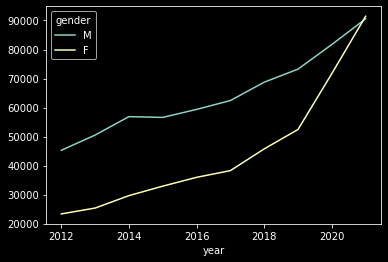

In [183]:
annual_counts = (data
              .pivot_table(columns="gender", index="year", values="salary", aggfunc="count")
              )

annual_counts[["M", "F"]].plot()

The number of women on the list has been increasing year over year.

<AxesSubplot:xlabel='year'>

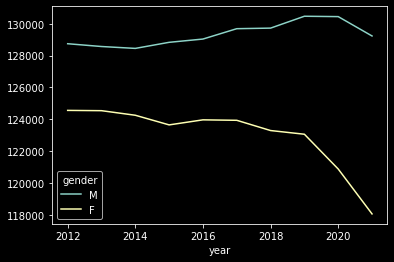

In [184]:
annual_gap = (data
              .loc[data["gender"].isin(["M", "F"]),:]
              .pivot_table(columns="gender", index="year", values="salary", aggfunc="mean")
              )

annual_gap[["M", "F"]].plot()

We can see that average pay has largely been decreasing as a whole over the last few years for both genders, but that the curve for women is steeper.

Let's calculate a new column with how much more the men make on average that year across all sectors to see the more direct impact on the pay gap.

In [185]:
annual_gap["difference"] = ((annual_gap["M"] - annual_gap["F"]) / annual_gap["M"]) * 100

annual_gap

gender,F,M,difference
year,,,
2012,"124,554.24","128,743.48",3.25
2013,"124,536.43","128,568.36",3.14
2014,"124,248.99","128,449.95",3.27
2015,"123,643.37","128,831.98",4.03
2016,"123,960.20","129,037.31",3.93
2017,"123,931.95","129,688.56",4.44
2018,"123,288.29","129,724.68",4.96
2019,"123,056.26","130,470.66",5.68
2020,"120,870.73","130,446.96",7.34


...and plot it so we can see it more clearly.

<AxesSubplot:xlabel='year'>

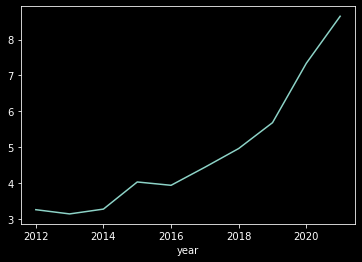

In [186]:
annual_gap["difference"].plot()

According to this analysis, the pay gap has gotten steadily more pronounced!

## 4. What can we conclude?

As mentioned before, this analysis comes with a load of caveats, and probably shouldn't be interpreted as 100% truth. It's one way to get some insight into the gender pay gap in public sector Ontario, where we have very little information.

\-30\-